In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint, LineString, LinearRing
from shapely.ops import cascaded_union, unary_union, transform
import datetime
import math
from scipy.ndimage.interpolation import shift
import scipy.interpolate as si
import shapely.wkt
from shapely.validation import explain_validity
import xarray as xr
import seaborn as sns
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines
from joblib import Parallel, delayed
import multiprocessing
from os.path import exists
import rasterio
from rasterio.windows import get_data_window,Window, from_bounds
from rasterio.plot import show
from itertools import product

/data2/lthapa/miniconda3/envs/ML_py/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
path_poly = '/data2/lthapa/ML_daily/fire_polygons/'
suffix_poly = 'Z_Day_Start.geojson'
start_time=12

fire_daily = gpd.read_file(path_poly+'ClippedFires2020_VIIRS_daily_'+str(start_time)+suffix_poly)

In [3]:
incidents_all = pd.read_csv('unique_fires_with_area_and_irwin_192021.csv')
ac = incidents_all[incidents_all['Fire Name']=='AUGUST COMPLEX']
wf = incidents_all[incidents_all['Fire Name']=='Williams Flats']
dix = incidents_all[incidents_all['Fire Name']=='DIXIE']

test_irwin_ids = [ac['irwinID'].values[0][2:38], wf['irwinID'].values[0][2:38], dix['irwinID'].values[0][2:38]]
print(test_irwin_ids)

['EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA', '7D2A6B0A-A161-44D9-BFF1-6A68CEA947C5', 'E9DB628D-DFB7-4C85-BCD6-1254574D946B']


In [4]:
august_complex = fire_daily.loc[fire_daily['irwinID']==test_irwin_ids[0]].to_crs('EPSG:4326')
august_complex.head()

,Local Day,irwinID,Incident Number,Fire Name,Current Day,Current Overpass,Lat Fire,Lon Fire,Number of NEW VIIRS points,NEW FRP,daily_area,geometry
457,2020-08-16,EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA,11843929.0,AUGUST COMPLEX,2020-08-17,1054.0,39.659444,-122.808889,43.0,1151.72,979.790318,"MULTIPOLYGON (((-122.73971 39.54484, -122.7398..."
496,2020-08-17,EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA,11843929.0,AUGUST COMPLEX,2020-08-18,1036.0,39.659444,-122.808889,43.0,94.50,612.707098,"MULTIPOLYGON (((-122.74350 39.58570, -122.7435..."
539,2020-08-18,EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA,11843929.0,AUGUST COMPLEX,2020-08-19,2200.0,39.659444,-122.808889,1251.0,61278.83,21188.718528,"MULTIPOLYGON (((-122.64720 39.59060, -122.6472..."
582,2020-08-19,EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA,11843929.0,AUGUST COMPLEX,2020-08-20,2142.0,39.659444,-122.808889,1603.0,26157.40,23298.905037,"MULTIPOLYGON (((-122.62975 39.56406, -122.6298..."
628,2020-08-20,EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA,11843929.0,AUGUST COMPLEX,2020-08-21,2212.0,39.659444,-122.808889,1097.0,61865.20,11703.096841,"MULTIPOLYGON (((-122.69277 39.52221, -122.6928..."


In [5]:
print(august_complex.crs)

EPSG:4326


In [6]:
file_list = os.listdir('../mtbs/2020/')

mtbs_bdrys = gpd.GeoDataFrame()
for file in file_list:
    if file.endswith('_burn_bndy.shp'):
        gdf_file = gpd.read_file('../mtbs/2020/'+file)
        mtbs_bdrys = pd.concat([mtbs_bdrys, gdf_file], axis=0)

mtbs_bdrys_merged = mtbs_bdrys.dissolve(by='irwinID').reset_index()
print(mtbs_bdrys_merged.head())

                                irwinID  \
0  007738AD-E20A-4B7D-9F77-6A5D50291B88   
1  00B3EDB2-87A4-4D0A-A834-4E1012BF9693   
2  013BE5E0-9AC8-4901-B7B7-E9DE5D0D14E2   
3  024CFE3D-2AA3-4BEC-BF99-7508B3B14C24   
4  03E930CE-D511-42C2-8808-08CF0FF43C7D   

                                            geometry               Event_ID  \
0  POLYGON ((-468656.027 1392775.681, -468656.313...  TX3553710125120200609   
1  MULTIPOLYGON (((-1997498.758 2824746.900, -199...  WA4592712198020200908   
2  POLYGON ((-1346730.496 1222215.244, -1346726.5...  AZ3309311057520200821   
3  POLYGON ((-805842.803 2639802.166, -805841.166...  MT4635510649020200715   
4  POLYGON ((-1369131.826 2208060.960, -1369137.6...  UT4180611268420200603   

    Incid_Name Incid_Type    Map_ID Map_Prog Asmnt_Type  BurnBndAc BurnBndLat  \
0        YANDY   Wildfire  10019331     MTBS    Initial       2722     35.507   
1   BIG HOLLOW   Wildfire  10021334     MTBS   Extended         13     45.932   
2    ROCKHOUSE   Wildfi

In [7]:
ac_bdry = mtbs_bdrys_merged.loc[mtbs_bdrys_merged['irwinID']==test_irwin_ids[0]].to_crs('EPSG:4326')
ac_bdry

,irwinID,geometry,Event_ID,Incid_Name,Incid_Type,Map_ID,Map_Prog,Asmnt_Type,BurnBndAc,BurnBndLat,...,Post_ID,Perim_ID,dNBR_offst,dNBR_stdDv,NoData_T,IncGreen_T,Low_T,Mod_T,High_T,Comment
369,EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA,"POLYGON ((-122.86088 39.49303, -122.86084 39.4...",CA3966012280920200817,AUGUST COMPLEX,Wildfire,10021108,MTBS,Extended,1068793,39.94,...,804503220210718,804503220201019,37,34,-970,-150,110,309,550,"CA4012512307320200818, CA4008712298420200819, ..."


In [8]:
print(ac_bdry.crs)

EPSG:4326


# plot the full polygon with the MTBS boundary

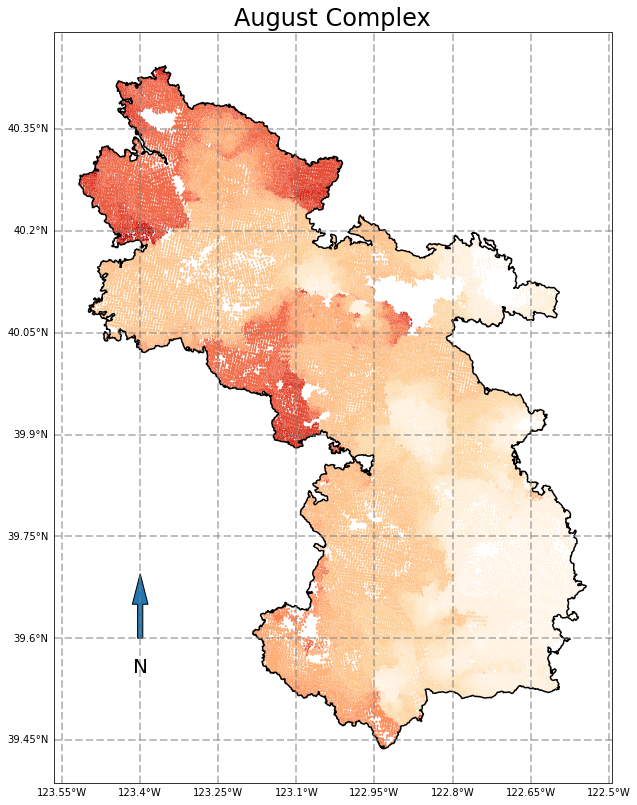

In [25]:
fig = plt.figure(figsize=(10,14))
ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
august_complex.plot(column='Current Day',cmap='OrRd', ax=ax)
ac_bdry.boundary.plot(ax=ax, edgecolor='k')
plt.arrow(-123.4, 39.6, 0, 0.05, width=0.01)
plt.annotate('N',(-123.4, 39.55), fontsize=20, horizontalalignment='center' )
plt.title('August Complex', fontsize=24)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
            linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.show()

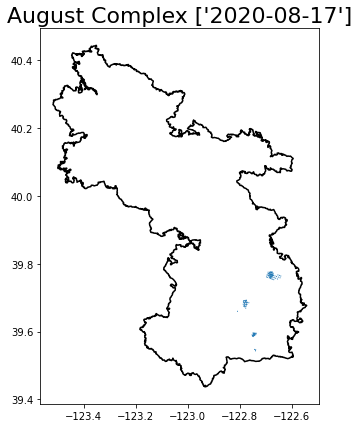

/data2/lthapa/miniconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':


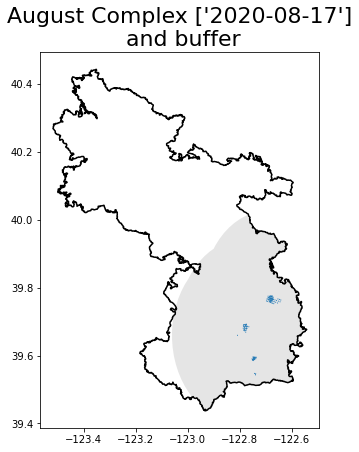

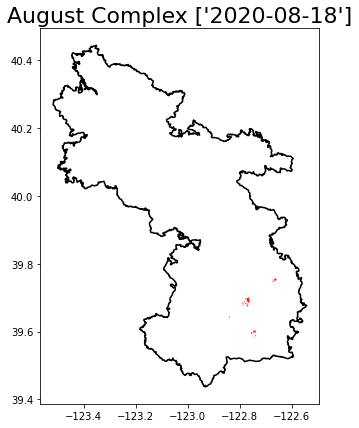

In [29]:
#first day
fig, ax = plt.subplots(figsize=(5,7))
august_complex.iloc[0:1].plot(column='Current Day', ax=ax)
ac_bdry.boundary.plot(ax=ax, edgecolor='k')
plt.title('August Complex '+str(august_complex.iloc[0:1]['Current Day'].values), fontsize=22)
plt.show()

#Searching for second day
day1_bf_clipped = gpd.clip(august_complex.iloc[0:1].buffer(0.25), ac_bdry)
fig, ax = plt.subplots(figsize=(5,7))
day1_bf_clipped.plot(color='k',alpha=0.1, ax=ax)
august_complex.iloc[0:1].plot(column='Current Day', ax=ax)
ac_bdry.boundary.plot(ax=ax, edgecolor='k')
plt.title('August Complex '+str(august_complex.iloc[0:1]['Current Day'].values) + '\n and buffer', fontsize=22)
plt.show()

#Second day, plus buffer
fig, ax = plt.subplots(figsize=(5,7))
#day1_bf_clipped.plot(color='k',alpha=0.1, ax=ax)
august_complex.iloc[1:2].plot(color='r', ax=ax)
ac_bdry.boundary.plot(ax=ax, edgecolor='k')
plt.title('August Complex '+str(august_complex.iloc[1:2]['Current Day'].values), fontsize=22)
plt.show()

In [10]:
august_complex.iloc[0:1].buffer(0.25)

/data2/lthapa/miniconda3/envs/ML_py/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


457    POLYGON ((-122.50083 39.46443, -122.50268 39.4...
dtype: geometry